In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13288.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/24201.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26556.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26076.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27577.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/27973.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/26452.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/10162.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12768.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/12551.jpg
/kaggle/input/face-expression-recognition-dataset/images/validation/surprise/13205.jpg
/kaggle/input/face-expression-recognition-d

In [2]:
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter

import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix


import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD

In [3]:
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [4]:
# General parameters
batch_size = 128
epochs = 50
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
folder_path="/kaggle/input/face-expression-recognition-dataset/images/"

In [6]:
def plot_exp(expression):
    plt.style.use('dark_background')
    plt.figure(figsize= (12,12))
    for i in range(1, 10, 1):
        plt.subplot(3,3,i)
        img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i+4], target_size=(pic_size, pic_size))
        plt.imshow(img)   
    plt.show()

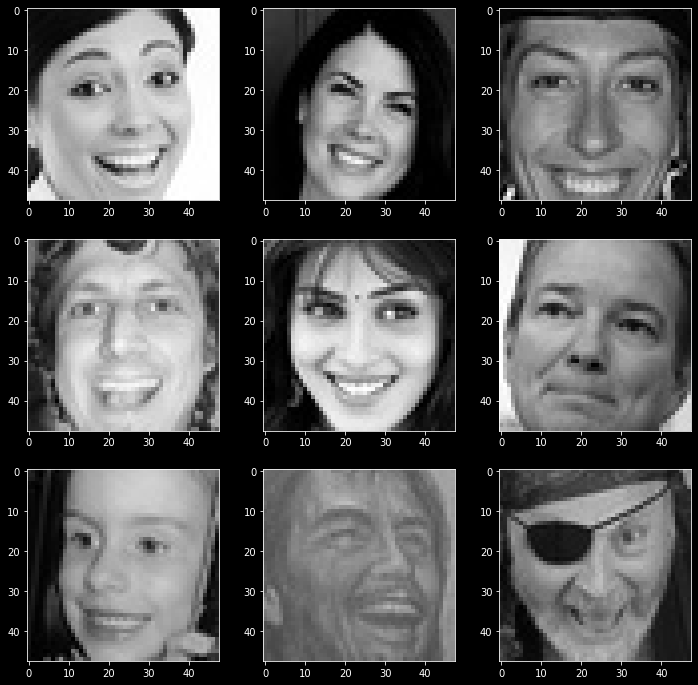

In [7]:
plot_exp('happy')

In [8]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [9]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")

In [10]:
print(train_dict)

{'/kaggle/input/face-expression-recognition-dataset/images/train/surprise': 3205, '/kaggle/input/face-expression-recognition-dataset/images/train/fear': 4103, '/kaggle/input/face-expression-recognition-dataset/images/train/angry': 3993, '/kaggle/input/face-expression-recognition-dataset/images/train/neutral': 4982, '/kaggle/input/face-expression-recognition-dataset/images/train/sad': 4938, '/kaggle/input/face-expression-recognition-dataset/images/train/disgust': 436, '/kaggle/input/face-expression-recognition-dataset/images/train/happy': 7164}


In [11]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [12]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{'surprise': 3205, 'fear': 4103, 'angry': 3993, 'neutral': 4982, 'sad': 4938, 'disgust': 436, 'happy': 7164}
{'surprise': 797, 'fear': 1018, 'angry': 960, 'neutral': 1216, 'sad': 1139, 'disgust': 111, 'happy': 1825}


In [13]:
label_train_dict = {'Expressions':train_dict.keys(), 'Count':train_dict.values}
label_val_dict = {'Expressions':val_dict.keys(), 'Count':val_dict.values}

In [14]:
label_train_dict

{'Expressions': dict_keys(['surprise', 'fear', 'angry', 'neutral', 'sad', 'disgust', 'happy']),
 'Count': <function dict.values>}

In [15]:
def plot_dist(my_dict, data):
    fig = px.bar(x=my_dict.values(),
             y=my_dict.keys(),
             orientation='h',
             color=my_dict.values(),
             title=data + ' Distribution',
             opacity=0.8,
             color_discrete_sequence=px.colors.diverging.curl,
             template='plotly_dark'
            )
    fig.update_xaxes()
    fig.show()

In [16]:
plot_dist(train_dict, "Training data")

In [17]:
plot_dist(val_dict, "Validation data")

In [18]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [19]:
train_set = datagen_train.flow_from_directory(folder_path+"train",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(folder_path+"validation",
                                              target_size = (pic_size,pic_size),
                                              color_mode = "rgb",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}              

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [20]:
# Create and compile model
model = Sequential()
model.add(ResNet50(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))
model.add(GlobalMaxPooling2D())
model.add(Dropout(0.5))
model.add(Dense(7,activation='softmax'))


2022-11-30 06:37:31.801619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:37:31.802573: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:37:31.810111: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:37:31.810896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 06:37:31.811660: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2, 2, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 7)                 14343     
Total params: 23,602,055
Trainable params: 23,548,935
Non-trainable params: 53,120
_________________________________________________________________


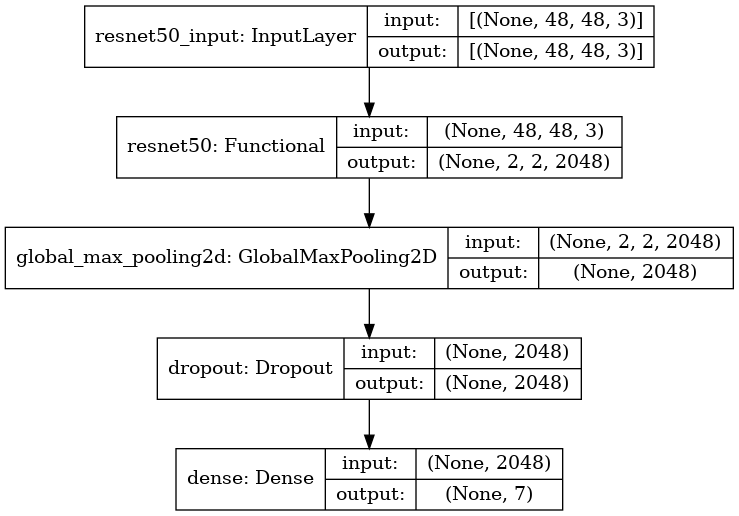

In [22]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [23]:
history = model.fit(train_set, 
                    validation_data = test_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = test_set.n//test_set.batch_size,
                   verbose=0)

2022-11-30 06:37:42.622720: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-30 06:37:50.108575: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


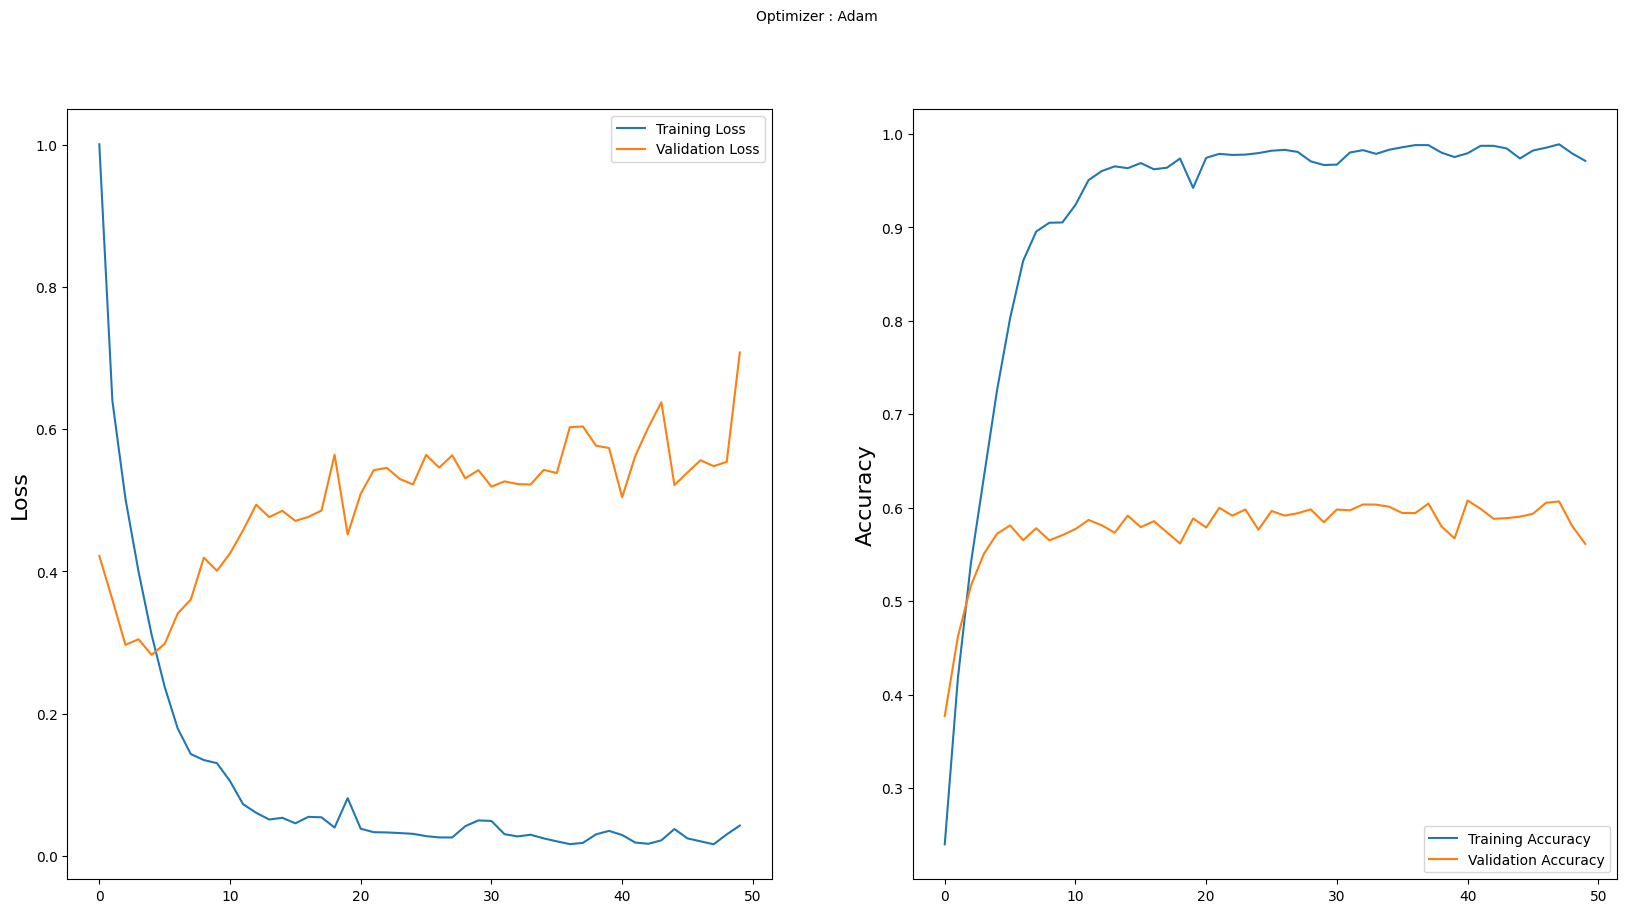

In [24]:
plt.style.use('default')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [25]:
results = model.evaluate(test_set)
preds   = model.predict(test_set)
print('The current model achieved a categorical accuracy of {}%!'.format(round(results[1]*100,2)))

56/56 [==============================] - 10s 185ms/step - loss: 0.7092 - accuracy: 0.5611
The current model achieved a categorical accuracy of 56.11%!


In [26]:
# compute predictions
predictions = model.predict(test_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_set.classes
class_names = test_set.class_indices.keys()

In [27]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

<Figure size 640x480 with 0 Axes>

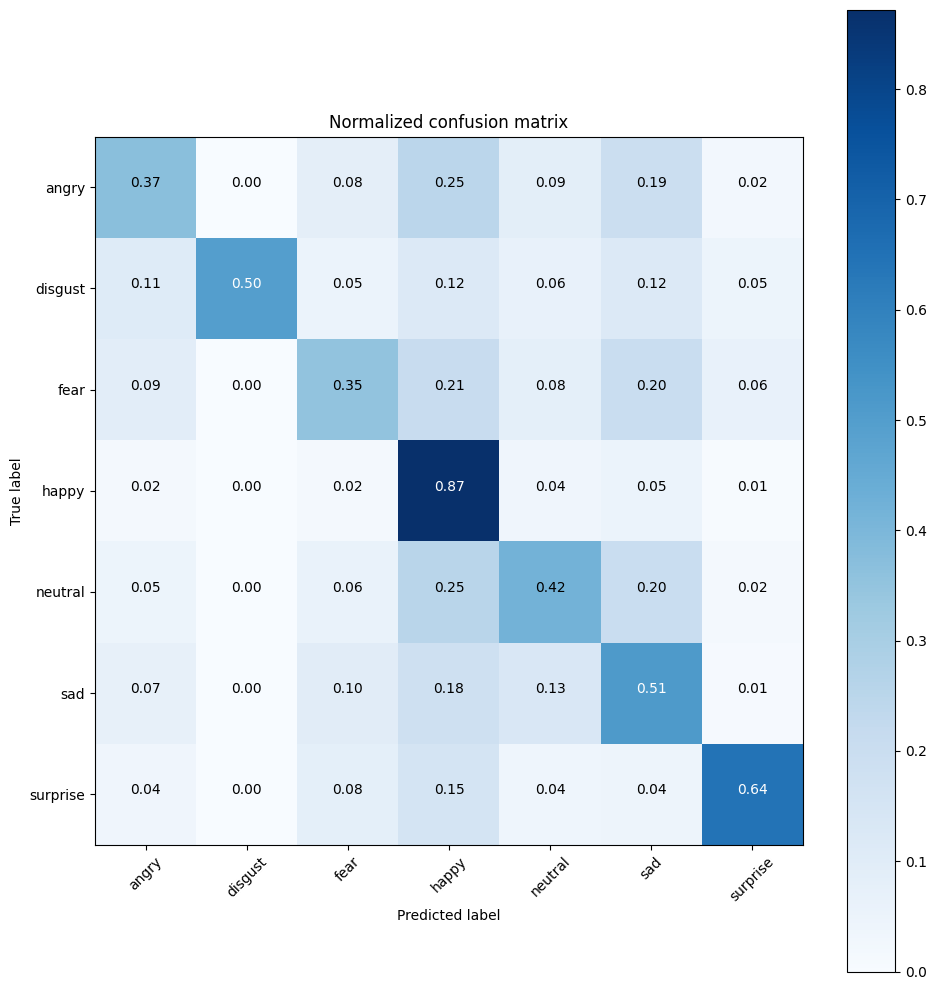

In [28]:
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()